In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import shap

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb


from sklearn.metrics import make_scorer ,mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler , FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate , cross_val_score

In [2]:
data_with_smiles=pd.read_csv("data\jjapac4894supp2.csv")
data=pd.read_csv("data\jjapac4894supp1.csv")

In [3]:
data.head()

,Paper No.,PCE max (%),VOC (V),JSC (mA/cm2),FF (%),"For VOC, JSC and FF, when only average values were available instead of actual values of the best devices, the average values were listed. These data were mainly obtained from tables and the main text of articles. Some data were from the supplymentary materials."
0,3,9.48,0.93,15.92,63.9,NaN
1,3,7.02,0.99,12.66,56.3,NaN
2,3,8.31,0.90,14.07,66.0,NaN
3,3,6.46,0.93,12.53,55.5,NaN
4,4,14.70,0.91,21.50,75.0,NaN


In [4]:
data=data.drop([data.columns[-1],data.columns[0]],axis=1)

In [5]:
data

,PCE max (%),VOC (V),JSC (mA/cm2),FF (%)
0,9.48,0.93,15.92,63.9
1,7.02,0.99,12.66,56.3
2,8.31,0.90,14.07,66.0
3,6.46,0.93,12.53,55.5
4,14.70,0.91,21.50,75.0
...,...,...,...,...
1351,1.76,1.15,4.51,34.0
1352,0.54,0.92,1.49,39.8
1353,0.23,0.74,0.85,37.3
1354,0.28,1.06,0.68,38.4


# DATA PREPROCESSING

In [6]:
data.describe()

,PCE max (%),VOC (V),JSC (mA/cm2),FF (%)
count,1356.000000,1356.000000,1356.000000,1355.000000
mean,7.260537,0.905183,13.550871,57.420951
std,3.714272,0.487485,5.886450,12.244684
min,0.000200,0.020000,0.010000,14.000000
25%,4.500000,0.800000,9.707500,51.000000
50%,7.500000,0.887000,14.400000,59.760000
75%,10.112500,0.946000,17.692500,66.720000
max,16.300000,9.610000,28.900000,86.000000


* Missing Values

In [7]:
print(data.isnull().sum())

PCE max (%)     0
VOC (V)         0
JSC (mA/cm2)    0
FF (%)          1
dtype: int64


In [8]:
missing_ff_row = data[data['FF (%)'].isnull()]
print(missing_ff_row)

     PCE max (%)  VOC (V)  JSC (mA/cm2)  FF (%)
886         10.0     0.94         15.51     NaN


In [9]:
data['FF (%)'].fillna(data['FF (%)'].mean(), inplace=True)
print(data.isnull().sum())

PCE max (%)     0
VOC (V)         0
JSC (mA/cm2)    0
FF (%)          0
dtype: int64


* Outliers

The "min" and "max" rows show that there are some extreme values in the dataset. For example, the maximum VOC value is 9.61 V, which is much higher than the median value of 0.887 V. We can confirm that with an other view

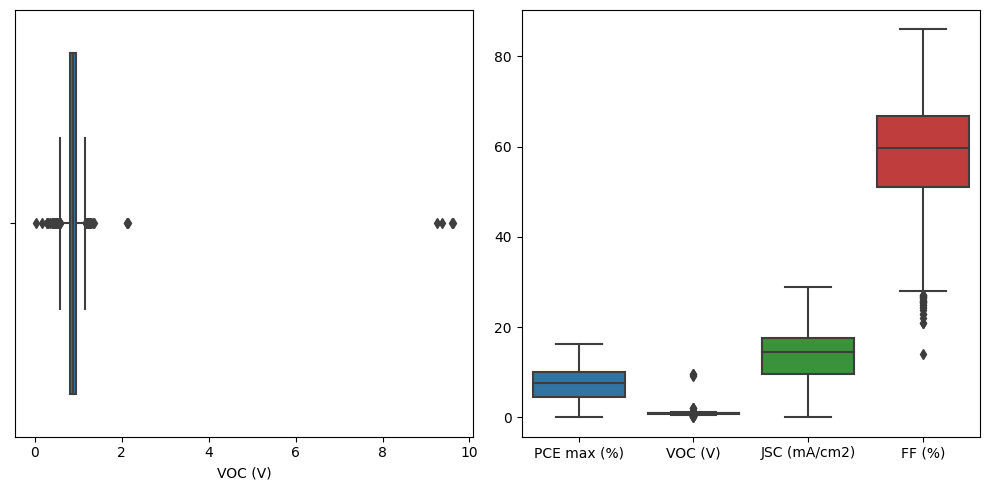

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.boxplot(x=data['VOC (V)'], ax=axs[0])
sns.boxplot(data=data, ax=axs[1])
plt.tight_layout()
plt.show()

In [11]:
# calculate the skewness coefficient of a variable
skewness = skew(data)
print(skewness) #15.97 >>>> 0

[-0.12607024 15.97199457 -0.2791207  -0.79855473]


In [12]:
#Possible Solution
# Apply a log transformation to the VOC column
data['VOC (V)'] = data['VOC (V)'] + 1
data['VOC (V)'] = np.log(data['VOC (V)'])

data.describe()

,PCE max (%),VOC (V),JSC (mA/cm2),FF (%)
count,1356.000000,1356.000000,1356.000000,1356.000000
mean,7.260537,0.633318,13.550871,57.420951
std,3.714272,0.121066,5.886450,12.240165
min,0.000200,0.019803,0.010000,14.000000
25%,4.500000,0.587787,9.707500,51.000000
50%,7.500000,0.634988,14.400000,59.730000
75%,10.112500,0.665776,17.692500,66.710000
max,16.300000,2.361797,28.900000,86.000000


* Standardization 

Because of differents values's scale  

In [13]:
# Create a StandardScalerobject , fit and transfrom data
scaler = StandardScaler()
X=data.drop(["PCE max (%)"],axis=1)
y=data["PCE max (%)"]
scaler.fit(X)
X_scaled = scaler.transform(X)
data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
data_scaled["PCE max (%)"] = y

In [14]:
data_scaled.describe()

,VOC (V),JSC (mA/cm2),FF (%),PCE max (%)
count,1.356000e+03,1.356000e+03,1.356000e+03,1356.000000
mean,2.301502e-16,1.539247e-17,2.421244e-16,7.260537
std,1.000369e+00,1.000369e+00,1.000369e+00,3.714272
min,-5.069461e+00,-2.301195e+00,-3.548724e+00,0.000200
25%,-3.762215e-01,-6.531592e-01,-5.247739e-01,4.500000
50%,1.380431e-02,1.443046e-01,1.887149e-01,7.500000
75%,2.682025e-01,7.038464e-01,7.591790e-01,10.112500
max,1.428239e+01,2.608498e+00,2.335720e+00,16.300000


<AxesSubplot:>

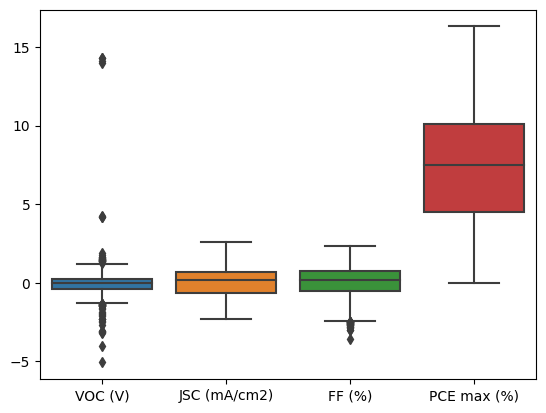

In [15]:
sns.boxplot(data=data_scaled)

* Distribution of reported PCE
* Schematics of expressions of somes molecules

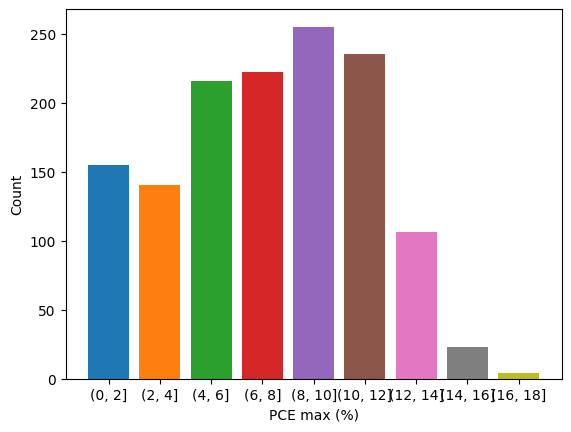

In [16]:
data['pce_pair'] = pd.cut(data['PCE max (%)'], bins=[0, 2, 4, 6, 8, 10,12, 14, 16 , 18])
pce_count = data.groupby('pce_pair').size()

colors = plt.cm.tab10(np.arange(len(pce_count)))

plt.bar(pce_count.index.astype(str), pce_count.values, color=colors)
plt.xlabel('PCE max (%)')
plt.ylabel('Count')
plt.show()


O=C1C2=C(C=CC=C2)C(/C1=C/C3=CC(C4(C5=CC=C(CCCCCC)C=C5)C6=CC=C(CCCCCC)C=C6)=C(S3)C7=C4C=C(C(SC(/C=C8/C(C(C=CC=C9)=C9C8=O)=C(C#N)\C#N)=C%10)=C%10C%11(C%12=CC=C(CCCCCC)C=C%12)C%13=CC=C(CCCCCC)C=C%13)C%11=C7)=C(C#N)/C#N


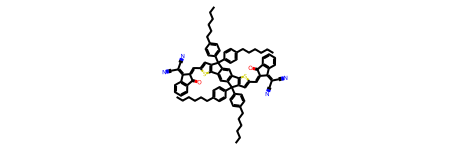

In [17]:
print(data_with_smiles['A SMILES'][0])
Chem.MolFromSmiles(data_with_smiles['A SMILES'][0])

* Check all the useful information that we may have missed

In [18]:
profile = ProfileReport(
    data_scaled,
    title="Profiling Report For D-NFA dataset ",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data_NFA-profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

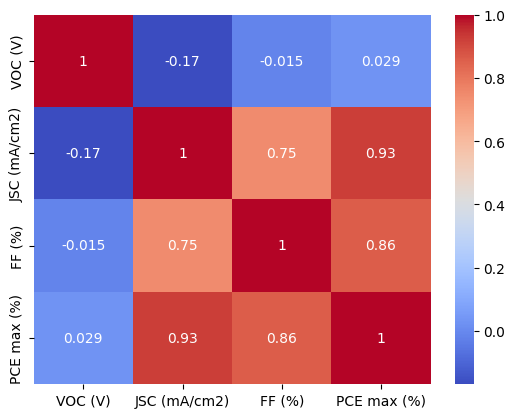

In [19]:
# We can also find the Correlation Matrix in our profile report , but this plot are simply more easier to interpret 
corr_matrix = data_scaled.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Feature importance using SHAP values based on

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

We don't have many descriptors so we SHAP Values will only based on Xgb and RF 

In [20]:
X=data_scaled.drop(["PCE max (%)"],axis=1)
y=data_scaled["PCE max (%)"]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


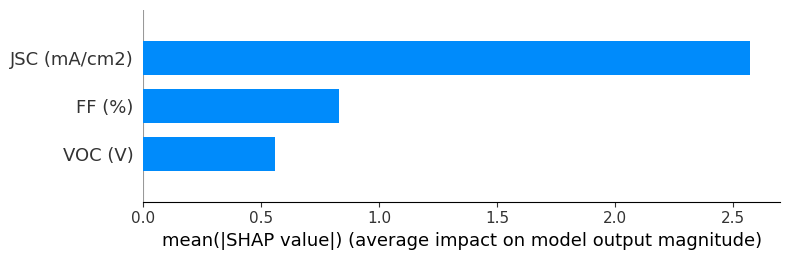

In [21]:
# With XGBOOST
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type='bar', show=False)

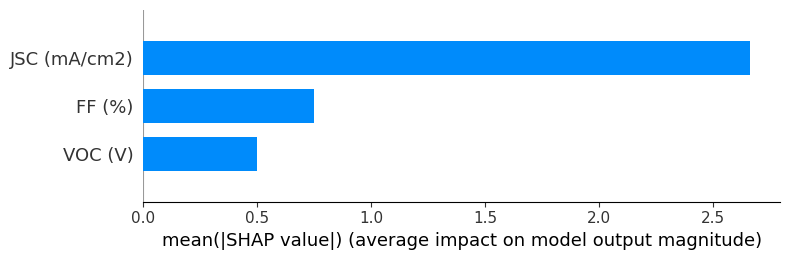

In [22]:
# # With Random Forest 
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type='bar', show=False)


Note :These graphs will only help us for our analysis, not for feature selection (because we don't have many descriptors).

# Model Construction 

To select the appropriate regression model , we must train and validate differents models on our train/validation data and compare the metrics

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

In [23]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

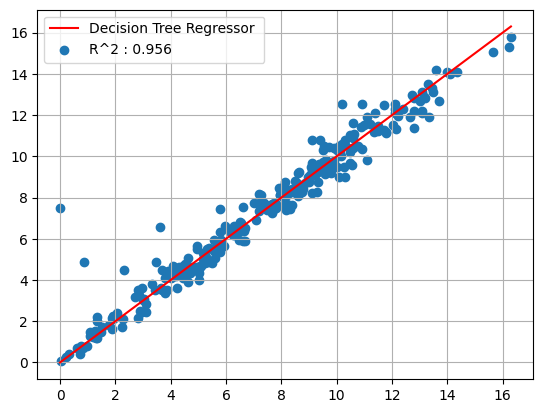

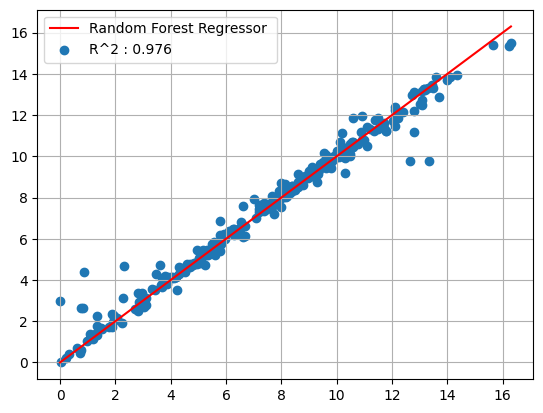

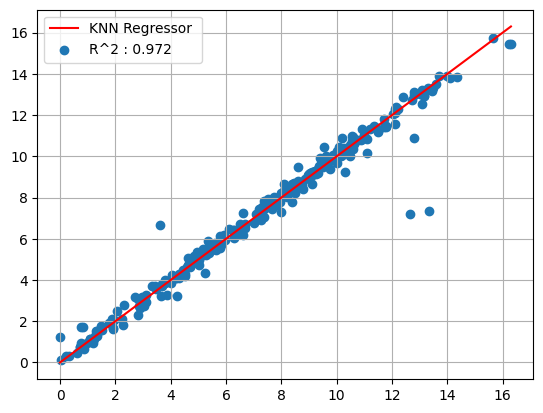

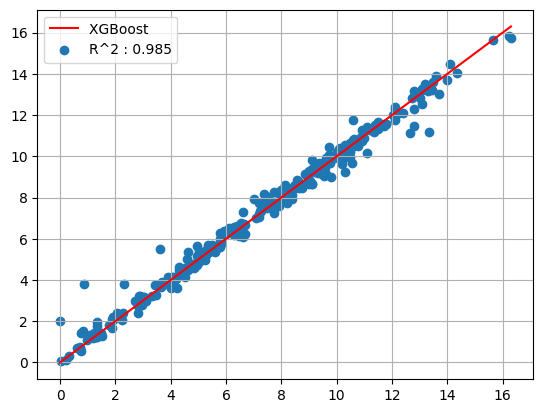

In [24]:
def add_pred_true_plot(y_validation,y_pred,name,score):
    
    plt.scatter(y_validation, y_pred)
    plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r')
    plt.legend([name,"R^2 : " + score])
    plt.grid()
    plt.show()

def train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics):
    results = []
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_validation)
        
        row = [name]
        for metric_name, metric_func in metrics.items():
            metric_value = metric_func(y_validation, y_pred)
            row.append(metric_value)
        results.append(row)
        
        add_pred_true_plot(y_validation,y_pred,name ,str(round(results[len(results)-1][3],3)))
        
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results



models = [
    ('Decision Tree Regressor ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor ', RandomForestRegressor(random_state=42)),
    ('KNN Regressor ', KNeighborsRegressor()),
    ('XGBoost ', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R^2': r2_score
}


df=train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics)


In [25]:
df

,Model,RMSE,MAE,R^2
0,Decision Tree Regressor,0.591372,0.453639,0.956136
1,Random Forest Regressor,0.320593,0.300325,0.976221
2,KNN Regressor,0.377684,0.264946,0.971986
3,XGBoost,0.195496,0.282467,0.985500


In [26]:
def train_validate_models_results_cv(X, y, models, metrics, cv):
    results = []
    for model_name, model in models :
        row = [model_name]
        for metric_name, metric_func in metrics.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring=metric_func)
            mean_score = np.mean(scores)
            row.append(mean_score)
        results.append(row)
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results

models = [
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('KNN Regressor', KNeighborsRegressor()),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score),
    'Max Error': make_scorer(max_error)
}


df_cv5=train_validate_models_results_cv(X, y, models, metrics,cv=5)


In [27]:
df_cv5

,Model,RMSE,MAE,R2,Max Error
0,Decision Tree Regressor,0.667973,0.410664,0.960071,4.298000
1,Random Forest Regressor,0.536863,0.266362,0.972032,4.323650
2,KNN Regressor,0.444532,0.260485,0.982451,3.359600
3,XGBoost,0.464790,0.250636,0.980194,3.802683


In [28]:
def plot_models_metrics(df , title):
    df_melted = pd.melt(df, id_vars=['Model'], var_name='metric', value_name='value')
    sns.catplot(x="Model", y="value", hue="metric", data=df_melted, kind="bar", height=6, aspect=2)
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()


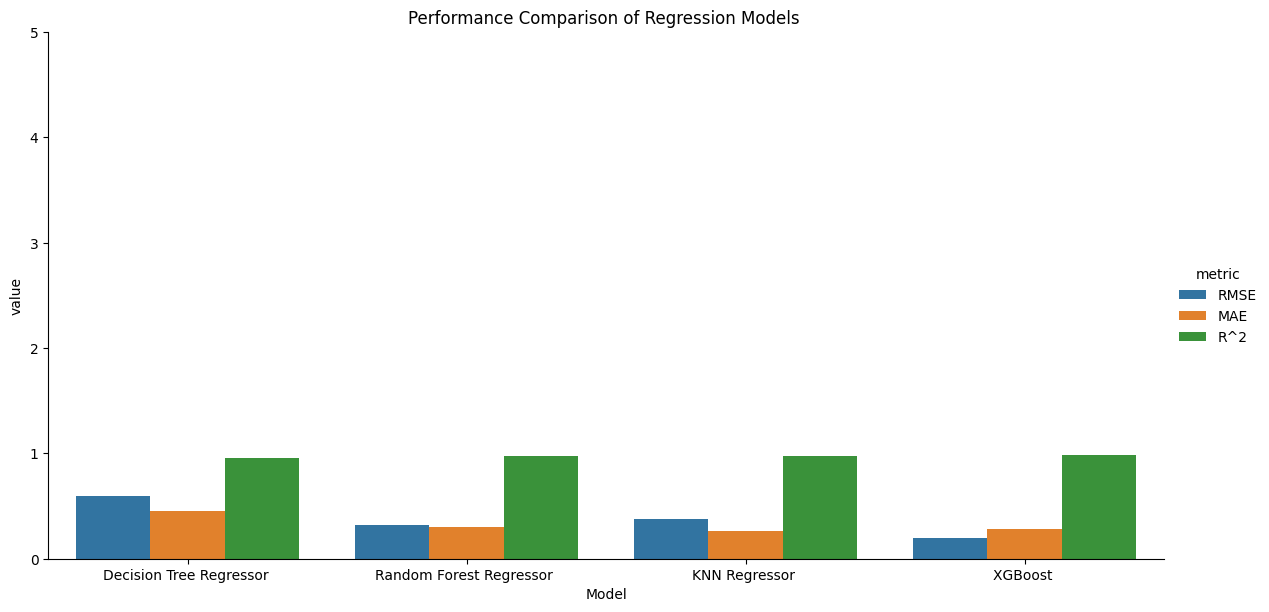

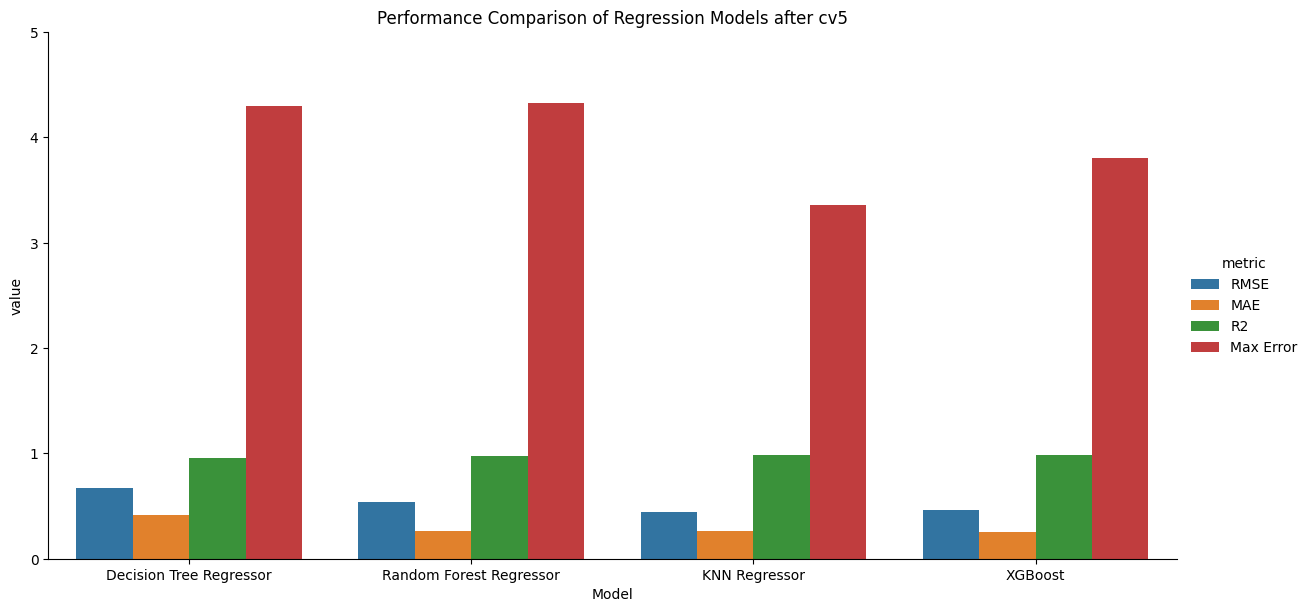

In [29]:
plot_models_metrics(df,title="Performance Comparison of Regression Models ")
plot_models_metrics(df_cv5,title="Performance Comparison of Regression Models after cv5")

In [49]:
from sklearn.model_selection import GridSearchCV

def grid_search_models(models, params, X, y):
    results_df = pd.DataFrame(columns=['model', 'best_params', 'score'])

    for name, model in models.items():
        param_grid = params[name]
        grid = GridSearchCV(model, param_grid, cv=5,scoring='r2')
        grid.fit(X, y)
        
        best_params = grid.best_params_
        best_score = grid.best_score_  # convert back to positive MSE

        results_df = results_df.append({'model': name, 'best_params': best_params, 'score': best_score}, ignore_index=True)

    return results_df



models = {
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

params = {
    'Decision Tree Regressor': {'max_depth': [2, 4, 6]},
    'Random Forest Regressor': {'n_estimators': [50, 100, 200]},
    'KNN Regressor': {'n_neighbors': [3, 5, 7]},
    'XGBoost':{'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6]}
}         


df_cv5_gridsearch =grid_search_models(models, params, X, y)


In [50]:
df_cv5_gridsearch

,model,best_params,score
0,Decision Tree Regressor,{'max_depth': 6},-0.933683
1,Random Forest Regressor,{'n_estimators': 100},-0.972032
2,KNN Regressor,{'n_neighbors': 7},-0.983043
3,XGBoost,"{'max_depth': 2, 'n_estimators': 200}",-0.988469



We can see that XGBOOST model with default parameters achieves best result with R^2 = 0.988469

# MODEL TEST (APPLICATION)

Dataset of 200 unique D:A combinations with corresponding PCE manually collected from the literature .
We will use that as new D-NFA comninaisons 

In [53]:
test=pd.read_csv("data\Pseudo_test_data.csv" , sep = ";")


In [54]:
test=test.drop([test.columns[-1],test.columns[0]],axis=1)
new_columns = {'Jsc(mA/cm2)': 'JSC (mA/cm2)', 'Voc(V)': 'VOC (V)','FF': 'FF (%)', 'PCE(%)': 'PCE max (%)'}

test = test.rename(columns=new_columns)
test['FF (%)']=test['FF (%)']*100
test[30:40]

,Donor,Acceptor,JSC (mA/cm2),VOC (V),FF (%),PCE max (%)
30,PM6,Y6,25.50,0.825,72.00,15.00
31,J52,BTA3,14.62,1.070,60.34,9.41
32,J52-Cl,BTA3,13.16,1.240,66.62,10.50
33,PDCBT-2F,IT-M,10.30,1.130,55.00,6.40
34,PTB7-Th,IEICO,13.30,0.900,60.00,7.20
35,PBQ-QF,IEICO-4F,22.40,0.740,64.00,10.50
36,PvBDTTAZ,O-IDTBR,16.20,1.080,65.00,11.40
37,PBDB-T,NCBDT,18.64,0.847,64.60,10.19
38,PTPD3T,ITIC,13.50,0.910,68.00,8.40
39,PTPD2T,ITIC,12.30,0.960,60.00,7.00


In [55]:
test.describe()

,JSC (mA/cm2),VOC (V),FF (%),PCE max (%)
count,200.000000,200.000000,200.000000,200.000000
mean,17.368050,0.903730,63.053150,9.890750
std,4.385205,0.112746,8.481698,3.086631
min,7.900000,0.660000,42.200000,4.100000
25%,14.250000,0.839750,57.400000,7.790000
50%,17.075000,0.890000,63.880000,9.600000
75%,20.425000,0.957750,69.450000,11.805000
max,27.700000,1.340000,81.500000,18.320000


In [56]:
X

,VOC (V),JSC (mA/cm2),FF (%)
0,0.199984,0.402620,0.529522
1,0.452952,-0.151399,-0.091613
2,0.070535,0.088223,0.701152
3,0.199984,-0.173491,-0.156996
4,0.113910,1.350909,1.436707
...,...,...,...
1351,1.091954,-1.536445,-1.914157
1352,0.157059,-2.049677,-1.440132
1353,-0.656349,-2.158441,-1.644453
1354,0.738614,-2.187332,-1.554552


In [57]:


def import_data():
    data=pd.read_csv("data\jjapac4894supp1.csv")
    data=data.drop([data.columns[-1],data.columns[0]],axis=1)
    data['VOC (V)'] = data['VOC (V)'] + 1
    data['VOC (V)'] = np.log(data['VOC (V)'])
    X=data.drop(["PCE max (%)"],axis=1)
    y=data["PCE max (%)"]
    return X,y

X_input , y_output = import_data()

def predict(data,scaler=scaler,X=X_input, y=y_output):
    
    
    scalers = StandardScaler()
    scalers.fit(X)
    X = scalers.transform(X)
    model=xgb.XGBRegressor(max_depth= 2, n_estimators= 200)
    model.fit(X, y.values)

    log_transform = FunctionTransformer(lambda x: np.log(x+1))
    data[['VOC (V)']] = log_transform.fit_transform(data[['VOC (V)']])
    data = scalers.transform(data)
    
    predictions = model.predict(data)
    return predictions


In [58]:
X_test=test[['VOC (V)','JSC (mA/cm2)', 'FF (%)' ]]
y_test=test["PCE max (%)"]

test["Predicted PCE"]= predict(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
test.sort_values(by=['Predicted PCE'], inplace=True, ascending=False)

In [60]:
test[0:10]

,Donor,Acceptor,JSC (mA/cm2),VOC (V),FF (%),PCE max (%),Predicted PCE
173,D18,Y6,27.70,0.859,76.60,18.22,17.285040
171,PM6,L8-BO,25.72,0.870,81.50,18.32,17.211807
48,PBDB-TF,BTP-eC9,26.20,0.839,81.10,17.80,16.810188
59,PBDB-TF,Aqx-2,25.38,0.860,76.25,16.64,16.619755
25,PBDB-TF,BTP-4Cl(Y7),25.40,0.867,75.00,16.50,16.619755
49,PBDB-TF,BTP-eC11,25.70,0.851,77.50,16.90,16.524717
122,PM6,BP4T-4F,26.30,0.839,77.70,17.10,16.399908
123,PM6,BP5T-4F,24.60,0.888,76.30,16.70,15.927349
119,PTQ10,Y6,24.81,0.870,75.10,16.21,15.699394
83,PBDB-TF,BTP-6F,25.90,0.810,72.80,15.30,15.425929


In [41]:
test.sort_values(by=['PCE max (%)'], inplace=True, ascending=False)
test[0:10]

,Donor,Acceptor,JSC (mA/cm2),VOC (V),FF (%),PCE max (%),Predicted PCE
171,PM6,L8-BO,25.72,0.870,81.50,18.32,16.421396
173,D18,Y6,27.70,0.859,76.60,18.22,16.410303
48,PBDB-TF,BTP-eC9,26.20,0.839,81.10,17.80,16.056492
122,PM6,BP4T-4F,26.30,0.839,77.70,17.10,15.975606
49,PBDB-TF,BTP-eC11,25.70,0.851,77.50,16.90,16.334778
123,PM6,BP5T-4F,24.60,0.888,76.30,16.70,16.285002
59,PBDB-TF,Aqx-2,25.38,0.860,76.25,16.64,16.216547
25,PBDB-TF,BTP-4Cl(Y7),25.40,0.867,75.00,16.50,16.225552
119,PTQ10,Y6,24.81,0.870,75.10,16.21,16.066677
83,PBDB-TF,BTP-6F,25.90,0.810,72.80,15.30,15.561440



The model is able to classify or identify the best combinations. On the other hand, it does not manage to predict correctly the candidates whose pce is >18%, which is understandable given the representability of its combinations in the training dataset. 

For optimization, we propose : 
* Collect more data with high PCE
* Building others models (ensemble models, neural networks, etc.)
* data augmentation techniques 
* Feature generation based on existing features

# Collect more data with high PCE

Additional data were collected and added to our initial dataset. It contains data of combinations with a PCE between 12% and 18.77%. This data will undoubtedly help us for better predictions.

In [ ]:
'''Y6-C2 , PM6-Ir1.5 , 0.84 26.1 78 17.1
Y6 , D18 , 0.86 27.7 77 18.2
BTP-eC9 , PM6 ,0.84	26.2 ,81 ,17.8
BTP-4Cl-12 , PM6 , 0.86 , 25.6 , 78 ,17.0
BTP-BO-4Cl , PM6 , 0.85 , 26.1 ,78 , 17.3
BTP-2F-ThCl , PM6 ,0.87 ,25.4 , 77 , 17.1'''

In [60]:
#Statistics for our new dataset

# Building others models

we'll test : 

* Ensemble Models
* Neural Network 
*


# Data augmentation techniques

# Feature generation based on existing features